# <font style="color:blue">Mask / No Mask Detector - YOLO v4 - Windows</font>
In this notebook we will train a custom object detector using YOLO v4,  Specially a face mask detector.

Just for your consideration, we will be creating a folder named YOLO. In the parent directory is located this notebook, but all other files are inside the YOLO folder. 

On the other hand, we will be working with Visual Studio 2019.  So you will have to make this minor change in cmake to work. Remember to fix the architecture if you are not using Visual Studio 2019 (default in other is 32-bits, we will be working on 64-bits).

Pre-requisites for this to work faster is to install CUDA Toolkit and cudnn libraries from the NVIDIA website.

The results of this windows machine where over a NVIDIA GeForce 1660Ti.

**NOTES**:
- *POWERSHELL DOWNLOADING PRETRAINED WEIGHTS TO TEST THE COMPILATION OF DARKNET IS REALLY SLOW, YOU WILL PREFFER TO DO IT MANUALLY*
- *THE OUTPUTS OF THE TRAINING ARE CLEARED, WE SHARED TO YOU THE RESULTS AND THE PRE-TRAINED WEIGHT, SEE THE README.MD*

### <font color="blue">0. Importing and Helper Functions </font>

In this section we will make use of our helper functions that will ease the use over the entire notebook.

Just some imports:
- os : path handling
- cv2: image processing
- IPython: for audio play
- datetime: for getting the timestamp
- random: for shuflying data
- subprocess: for calling functions of the system

In [1]:
import random
import os
import subprocess
import sys
import cv2
import matplotlib.pyplot as plt
from IPython.display import Audio
from datetime import datetime
%matplotlib inline

This is where a nice soundwave is located on the machine for just tell us when the training ended or when processing YOLO video when it ends to patch the video with the predictions.

Trainings vary from 2 hrs to 30 hrs so is good if you are near to hear that it finished.

In [2]:
sound_file = 'C:\Windows\Media\Ring10.wav'

The utility function below will help us to display the test image and its predicted labels, also will save the picture on the results folder

In [3]:
# Utility function to display the output

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")
    
    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    
    file_name = imagePath.split('\\')
    file_name_parts = file_name[2].split('.')
    name_only = file_name_parts[0]
    now = datetime.now() # current date and time
    build = now.strftime("%m-%d-%Y_%H_%M_%S")
    file_save_path = os.path.join(file_name[0], 'result', 'yolov4')
    save_name = os.path.join(file_save_path, name_only + '-yolov4--' + build +'.png')
    plt.savefig(save_name)    
    
    plt.show()    

This class will help us to read a file and modify their lines in a easy way.  An example of usage is in comments below.  On the other hand you will use it on the entire document.

In [4]:
# Utility class to modify files

# Get a file handler
# mkf = FileMod(doc='.\Makefile')  

# Load the file and view the line numbers
# mkf.load(doc='.\Makefile')

# make a dictionary to modify the file
# mkf_dict = dict({
#                  0:'GPU=1', 
#                  2: 'CUDNN_HALF=1'
#                })
# mkf.mod(doc='.\Makefile', mod_lines=mkf_dict)

# view the print out without line numbers (optional)
# mkf.view()   # view 20 lines
# ... or ...
# mkf.view(10) # view 10 lines

class FileMod():
    def __init__(self, doc=None, *args, **kwargs):
        super(FileMod, self).__init__()
        
        self.mode  = 'r'  # default = read
        self.file  = doc # path of file
        self.dict  = {}   # dict to modify
        self.lines = []   #lines of file

    def load(self, doc=None):
        try:
            if doc==None:
                doc=self.file
            with open(doc, self.mode) as file:
                # read a list of lines into data
                data = file.readlines()
            self.lines = data
            for i, string in enumerate(self.lines):
                print(f"{i}:{string}")
        except Exception as e:
            print(e)

    def mod(self, mod_lines=None):
        # and write everything back
        if mod_lines == None:
            return
        doc = self.file
        self.mode = 'w'
        for lines, data in mod_lines.items():
            string = data + '\n'
            self.lines[lines] = string
            print(f"mod {lines} as {string}")
        with open(doc, 'w') as file:
            file.writelines(self.lines)
        self.mode = 'r'

    def view(self, lines=None):
        if lines == None:
            lines = 20
        doc = self.file
        with open(doc, self.mode) as file:
            # read a list of lines into data
            data = file.readlines()
        for line_num, line in enumerate(data):
            if line_num > lines - 1:
                break
            print(f"{line}\n")

In each step I am doing a dummy *ls* for seein in which folder we are

In [5]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test

06/08/2020  01:55 PM    <DIR>          .
06/08/2020  01:55 PM    <DIR>          ..
06/08/2020  10:43 AM    <DIR>          .ipynb_checkpoints
06/08/2020  01:34 PM         6,208,168 Facial Mask Detector - YOLO v4 - Windows.ipynb
               1 File(s)      6,208,168 bytes
               3 Dir(s)  1,739,018,719,232 bytes free


We will then create a folder named *YOLO* and will start working from here

In [6]:
%mkdir YOLO
%cd YOLO

c:\Users\issai\Downloads\Test\YOLO


### <font color="blue">1.  Download Alexey AB YOLO repository to our google drive *yolov3* folder</font>
We now will download the well maintained repository of a YOLO expert, because Joseph Redmon will not continue working on YOLO and because this repo work very well on Windows.

In [7]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
Updating files:  94% (1897/2004)
Updating files:  95% (1904/2004)
Updating files:  96% (1924/2004)
Updating files:  97% (1944/2004)
Updating files:  98% (1964/2004)
Updating files:  99% (1984/2004)
Updating files: 100% (2004/2004)
Updating files: 100% (2004/2004), done.


### <font color="blue">2.  Compile Darknet</font>
Next, some strings on the Makefile needs to be modified before we build darknet from the source.

In [8]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO

06/08/2020  01:55 PM    <DIR>          .
06/08/2020  01:55 PM    <DIR>          ..
06/08/2020  01:55 PM    <DIR>          darknet
               0 File(s)              0 bytes
               3 Dir(s)  1,738,974,756,864 bytes free


In [9]:
%cd darknet\build

c:\Users\issai\Downloads\Test\YOLO\darknet\build


In [10]:
mkf = FileMod('..\Makefile')
mkf.load()

0:GPU=0

1:CUDNN=0

2:CUDNN_HALF=0

3:OPENCV=0

4:AVX=0

5:OPENMP=0

6:LIBSO=0

7:ZED_CAMERA=0 # ZED SDK 3.0 and above

8:ZED_CAMERA_v2_8=0 # ZED SDK 2.X

9:

10:# set GPU=1 and CUDNN=1 to speedup on GPU

11:# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher

12:# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)

13:

14:USE_CPP=0

15:DEBUG=0

16:

17:ARCH= -gencode arch=compute_30,code=sm_30 \

18:      -gencode arch=compute_35,code=sm_35 \

19:      -gencode arch=compute_50,code=[sm_50,compute_50] \

20:      -gencode arch=compute_52,code=[sm_52,compute_52] \

21:	    -gencode arch=compute_61,code=[sm_61,compute_61]

22:

23:OS := $(shell uname)

24:

25:# Tesla V100

26:# ARCH= -gencode arch=compute_70,code=[sm_70,compute_70]

27:

28:# GeForce RTX 2080 Ti, RTX 2080, RTX 2070, Quadro RTX 8000, Quadro RTX 6000, Quadro RTX 5000, Tesla T4, XNOR Tensor Cores

29:# ARCH= -gencode arch=compute_75

In [11]:
mkfdict = dict({
                0:'GPU=1',
                1:'CUDNN=1',
                3:'OPENCV=1',
                4:'AVX=1'
              })
mkf.mod(mod_lines=mkfdict)

mod 0 as GPU=1

mod 1 as CUDNN=1

mod 3 as OPENCV=1

mod 4 as AVX=1



In [12]:
mkf.view()

GPU=1


CUDNN=1


CUDNN_HALF=0


OPENCV=1


AVX=1


OPENMP=0


LIBSO=0


ZED_CAMERA=0 # ZED SDK 3.0 and above


ZED_CAMERA_v2_8=0 # ZED SDK 2.X





# set GPU=1 and CUDNN=1 to speedup on GPU


# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher


# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)





USE_CPP=0


DEBUG=0





ARCH= -gencode arch=compute_30,code=sm_30 \


      -gencode arch=compute_35,code=sm_35 \


      -gencode arch=compute_50,code=[sm_50,compute_50] \




In [13]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO\darknet\build

06/08/2020  01:55 PM    <DIR>          .
06/08/2020  01:55 PM    <DIR>          ..
06/08/2020  01:55 PM    <DIR>          darknet
               0 File(s)              0 bytes
               3 Dir(s)  1,738,974,752,768 bytes free


In [14]:
print("[INFO] - Building Darknet with cmake")
!cmake -G "Visual Studio 16 2019" ..

[INFO] - Building Darknet with cmake
-- Selecting Windows SDK version 10.0.18362.0 to target Windows 10.0.18363.
-- The C compiler identification is MSVC 19.24.28316.0
-- The CXX compiler identification is MSVC 19.24.28316.0
-- Check for working C compiler: C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.24.28314/bin/Hostx64/x64/cl.exe
-- Check for working C compiler: C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.24.28314/bin/Hostx64/x64/cl.exe - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.24.28314/bin/Hostx64/x64/cl.exe
-- Check for working CXX compiler: C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.24.28314/bin/Hostx64/x64/cl.exe - works
-- Detecting CXX compiler ABI info


In [15]:
print("[INFO] - Building Darknet Release Mode")
!cmake --build . --target ALL_BUILD
print("[INFO] - End of building darknet!")

[INFO] - Building Darknet Release Mode
Microsoft (R) Build Engine version 16.4.0+e901037fe for .NET Framework
Copyright (C) Microsoft Corporation. All rights reserved.

  Checking Build System
  Building Custom Rule C:/Users/issai/Downloads/Test/YOLO/darknet/CMakeLists.txt
  Compiling CUDA source file ..\src\activation_kernels.cu...
  
  C:\Users\issai\Downloads\Test\YOLO\darknet\build>"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\bin\nvcc.exe" -gencode=arch=compute_75,code=\"sm_75,compute_75\" --use-local-env -ccbin "C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Tools\MSVC\14.24.28314\bin\HostX64\x64" -x cu -rdc=true -IC:\Users\issai\Downloads\Test\YOLO\darknet\include -IC:\Users\issai\Downloads\Test\YOLO\darknet\src -IC:\Users\issai\Downloads\Test\YOLO\darknet\3rdparty\stb\include -I"C:\OpenCV\OpenCV-4.3.0\opencv\build\install\include" -I"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\include" -IC:\Users\issai\Downloads\Test\YOLO\darknet\3rdpa

In [16]:
print("[INFO] - Final Steps")
!cmake --build . --target INSTALL
print("[INFO] - You are done for start training or detecting!")

[INFO] - Final Steps
Microsoft (R) Build Engine version 16.4.0+e901037fe for .NET Framework
Copyright (C) Microsoft Corporation. All rights reserved.

  dark.vcxproj -> C:\Users\issai\Downloads\Test\YOLO\darknet\build\Debug\darkd.dll
  darknet.vcxproj -> C:\Users\issai\Downloads\Test\YOLO\darknet\build\Debug\darknet.exe
  uselib.vcxproj -> C:\Users\issai\Downloads\Test\YOLO\darknet\build\Debug\uselib.exe
  uselib_track.vcxproj -> C:\Users\issai\Downloads\Test\YOLO\darknet\build\Debug\uselib_track.exe
  -- Install configuration: "Debug"
  -- Installing: C:/Users/issai/Downloads/Test/YOLO/darknet/darkd.lib
  -- Installing: C:/Users/issai/Downloads/Test/YOLO/darknet/darkd.dll
  -- Installing: C:/Users/issai/Downloads/Test/YOLO/darknet/include/darknet/darknet.h
  -- Installing: C:/Users/issai/Downloads/Test/YOLO/darknet/include/darknet/yolo_v2_class.hpp
  -- Installing: C:/Users/issai/Downloads/Test/YOLO/darknet/uselib.exe
  -- Installing: C:/Users/issai/Downloads/Test/YOLO/darknet/darknet

### <font color="blue">3. Move DLLs To The Root Folder of Darknet</font>

Darknet will need phtreadVC2.dll to load correctly so we will be putting it on the root of the darknet folder for simplifying things.

In [17]:
%cd ..\

c:\Users\issai\Downloads\Test\YOLO\darknet


In [18]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO\darknet

06/08/2020  01:57 PM    <DIR>          .
06/08/2020  01:57 PM    <DIR>          ..
06/08/2020  01:55 PM    <DIR>          .circleci
06/08/2020  01:55 PM    <DIR>          .github
06/08/2020  01:55 PM               638 .gitignore
06/08/2020  01:55 PM            10,798 .travis.yml
06/08/2020  01:55 PM    <DIR>          3rdparty
06/08/2020  01:57 PM    <DIR>          build
06/08/2020  01:55 PM             8,510 build.ps1
06/08/2020  01:55 PM             2,101 build.sh
06/08/2020  01:55 PM    <DIR>          cfg
06/08/2020  01:55 PM    <DIR>          cmake
06/08/2020  01:55 PM            21,052 CMakeLists.txt
06/08/2020  01:56 PM         5,057,024 darkd.dll
06/08/2020  01:56 PM            19,894 darkd.lib
06/08/2020  01:57 PM         4,527,616 darknet.exe
06/08/2020  01:55 PM            20,582 darknet.py
06/08/2020  01:55 PM             4,125 darknet_video.py
0

In [19]:
!copy 3rdparty\pthreads\bin\* .

3rdparty\pthreads\bin\pthreadGC2.dll
3rdparty\pthreads\bin\pthreadVC2.dll
        2 file(s) copied.


### <font color="blue">4. Cloning the Pre-Trained Weights</font>
We will be doing a compilation test with the pre-trained weights of YOLO v3 (just this time).

In [20]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO\darknet

06/08/2020  01:57 PM    <DIR>          .
06/08/2020  01:57 PM    <DIR>          ..
06/08/2020  01:55 PM    <DIR>          .circleci
06/08/2020  01:55 PM    <DIR>          .github
06/08/2020  01:55 PM               638 .gitignore
06/08/2020  01:55 PM            10,798 .travis.yml
06/08/2020  01:55 PM    <DIR>          3rdparty
06/08/2020  01:57 PM    <DIR>          build
06/08/2020  01:55 PM             8,510 build.ps1
06/08/2020  01:55 PM             2,101 build.sh
06/08/2020  01:55 PM    <DIR>          cfg
06/08/2020  01:55 PM    <DIR>          cmake
06/08/2020  01:55 PM            21,052 CMakeLists.txt
06/08/2020  01:56 PM         5,057,024 darkd.dll
06/08/2020  01:56 PM            19,894 darkd.lib
06/08/2020  01:57 PM         4,527,616 darknet.exe
06/08/2020  01:55 PM            20,582 darknet.py
06/08/2020  01:55 PM             4,125 darknet_video.py
0

In [21]:
# We will download the pre-trained weights of yolov3 just this time to test the darknet compilation
# This will take a lot of time, you preferibly will want to do it manually
!powershell -c "(New-Object System.Net.WebClient).DownloadFile('https://pjreddie.com/media/files/yolov3.weights', 'yolov3.weights')"
Audio(sound_file, autoplay=True)

### <font color="blue">5. Test The Compilation</font>

If everything is OK, in predictions.jpg you will get the image with their bounding boxes and classifications of the classes detected by yolo.

In [22]:
!darknet detect cfg\yolov3.cfg yolov3.weights data\dog.jpg

 _DEBUG is used 
 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 

 seen 64, trained: 32013 K-images (500 Kilo-batches_64) 
data\dog.jpg: Predicted in 112.485000 milli-seconds.
bicycle: 99%
dog: 100%
truck: 93%


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce GTX 1660 Ti 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104 x 104 x 128 ->

### <font color="blue">6.  Download the *Mask / No Mask Dataset*</font>
Download the curated dataset of face mask and not facemask to our dataset folder, but first lets create a dataset folder.

Usually i like to be very organized.

In [23]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO\darknet

06/08/2020  02:21 PM    <DIR>          .
06/08/2020  02:21 PM    <DIR>          ..
06/08/2020  01:55 PM    <DIR>          .circleci
06/08/2020  01:55 PM    <DIR>          .github
06/08/2020  01:55 PM               638 .gitignore
06/08/2020  01:55 PM            10,798 .travis.yml
06/08/2020  01:55 PM    <DIR>          3rdparty
06/08/2020  01:57 PM    <DIR>          build
06/08/2020  01:55 PM             8,510 build.ps1
06/08/2020  01:55 PM             2,101 build.sh
06/08/2020  01:55 PM    <DIR>          cfg
06/08/2020  01:55 PM    <DIR>          cmake
06/08/2020  01:55 PM            21,052 CMakeLists.txt
06/08/2020  01:56 PM         5,057,024 darkd.dll
06/08/2020  01:56 PM            19,894 darkd.lib
06/08/2020  01:57 PM         4,527,616 darknet.exe
06/08/2020  01:55 PM            20,582 darknet.py
06/08/2020  01:55 PM             4,125 darknet_video.py
0

In [24]:
%cd ../

c:\Users\issai\Downloads\Test\YOLO


Next we will download the dataset to this root folder *YOLO*, decompress it on another folder called *dataset* and finally erase the zip file.

In [25]:
!powershell -c "(New-Object System.Net.WebClient).DownloadFile('https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1', '.\kaggle_and_no-mask_dataset.zip')"
!powershell -c "expand-archive -path 'kaggle_and_no-mask_dataset.zip' -destinationpath 'dataset'"
!powershell -c "remove-item -path 'kaggle_and_no-mask_dataset.zip'"

### <font color="blue">7.  Prepare the Train and Test Files</font>
This code provided creates two files, one for the training images and other for the test images.

The dataset is divided in:
- 80% training set 
- 20% test set

In [26]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO

06/08/2020  02:23 PM    <DIR>          .
06/08/2020  02:23 PM    <DIR>          ..
06/08/2020  02:21 PM    <DIR>          darknet
06/08/2020  02:23 PM    <DIR>          dataset
               0 File(s)              0 bytes
               4 Dir(s)  1,738,027,814,912 bytes free


In [27]:
image_dir = "dataset"
f_val = open("DS_test.txt", 'w')
f_train = open("DS_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

### <font color="blue">8.  Prepare and Upload the configuration files</font>

For train and use yolo we need to prepare the neccesary files, finally we will upload to our yolov4 folder.

#### <font color="blue">8.1. Data Setup</font>
In the file **`yolov3-mask_nomask-setup.data`**(uploaded to github and included here), we provided the correct specification of our paths.

Below is the content of this file:
```
classes = 2
train  = DS_train.txt
valid  = DS_test.txt
names = FacialMaskDetector/yolov3/config/yolov3.names
backup = FacialMaskDetector/yolov3/backup/
```

#### <font color="blue">8.2. Training Config File</font>
We also need to provide the  **`yolov3-mask_nomask-train.cfg`**. Based on the default file of darknet folder over the VOC dataset, yolov3-voc.cfg.

#### <font color="blue">8.2.1 Batch hyper-parameter in YOLOv3</font>
We maintain the batch size and the subdivision batch as the default of the file.  That's 20 images to feed in two subgroups.

For the *test configuration file* we will set these params to 1 because we will feed an image.
```
batch=20
subdivisions=10
```
#### <font color="blue">8.2.2 Subdivisions configuration parameter in YOLOv3</font>
For feeding the GPU correcly we slow the training, this action will ensure our machine will be able to train the detector but you could play with this parameter.

In testing mode this will be equal to 1.

### <font color="blue">8.2.3 Width, Height, Channels</font>
A higher resolution the detection will be better but you will sacrifice the time of training.
```
width=352
height=352
channels=3
```
### <font color="blue">8.2.4 Momentum and Decay</font>
These hyperparameters we will maintain as is.
```
momentum=0.949
decay=0.0005
```

### <font color="blue">8.2.5 Learning Rate, Steps, Scales, Burn In (warm-up)</font>
Again, we will be maintaining these hyperparamters as default.  The learning rate will be changed over the 800th iteration.

```
learning_rate=0.0013
policy=steps
steps=6000
scales=.1,.1
burn_in=600
```


### <font color="blue">8.2.6 Data augmentation</font>
For various lighting conditions and different color ranges (over other color spaces).  Sometimes its good to change the angle because a few objects could be rotated.  A facemask in this case we will maintain at 0 degrees but could be augmented to 3° or something low because we are detecting people.
```
angle=0
saturation = 1.5
exposure = 1.5
hue=.1
```

#### <font color="blue">8.2.7 Number of iterations</font>
Process 2000*n_classes iterations run as recommended.  But we will keep in a higher number to see the performance.
```
max_batches=6000
```

#### <font color="blue">8.2.8 Change filters parameter in conv layers [Important for multiple objects]</font>
Fini in the file the conv. layer before the yolo layer with the equation:

**`filters=( classes + 5 ) * 3`**

Our yolo classes are 2, so filters = 21.

### <font color="blue">8.3. yolov3.names file </font>
Specify the classes as...
- Mask (Class 0), 
- No-Mask (Class 1) 

... class labels.

### <font color="blue">8.4. Improving The Network </font>
We observed that on the AlexeyAB repo recommended change some hyperparameters for improving the training accuracy.  These parameters modified are:
- stride=4, near line 890
- layers=23, near line 894
- added max=200 or above at the end of the file

### <font color="blue">9. Cloning the configuration Repository</font>
This repository is prepared with the desired configuration for yolov3 and yolov4.

In this case we will be using yolo v4.  The structure of the folder is as follows:

```
/FacialMaskDetector
├── results
│   ├── yolov3
│   │       ├── README.md
│   ├── yolov4
│           ├── README.md
├── test
│   ├── test-image1.jpg
│   ├── test-image2.jpg
│   ├── test-image3.jpg
│   ├── test-image4.jpg
│   ├── test-video1.jpg
│   ├── test-video2.jpg
├── yolov3
│       ├── backup
│       │   ├── README.md
│       ├── config
│       │   ├── yolov3-mask_nomask-setup.data
│       │   ├── yolov3-mask_nomask-test.cfg
│       │   ├── yolov3-mask_nomask-train.cfg
│       │   ├── yolov3.names
│       ├── weights
│           ├── README.md
├── yolov4
│       ├── backup
│       │   ├── README.md
│       ├── config
│       │   ├── yolov4-mask_nomask-setup.data
│       │   ├── yolov4-mask_nomask-test.cfg
│       │   ├── yolov4-mask_nomask-train.cfg
│       │   ├── yolov4.names
│       ├── weights
│           ├── README.md
├── README.md
```

This will ease for us the way of training and inference.

In [28]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO

06/08/2020  02:24 PM    <DIR>          .
06/08/2020  02:24 PM    <DIR>          ..
06/08/2020  02:21 PM    <DIR>          darknet
06/08/2020  02:23 PM    <DIR>          dataset
06/08/2020  02:24 PM            12,426 DS_test.txt
06/08/2020  02:24 PM            47,956 DS_train.txt
               2 File(s)         60,382 bytes
               4 Dir(s)  1,738,023,391,232 bytes free


In [29]:
!git clone https://github.com/issaiass/FacialMaskDetector.git

Cloning into 'FacialMaskDetector'...


### <font color="blue">10. Review Hyperparameters</font>

Here we will set the hyperparamters for training the YOLO v4 model.
Below python variables to be the shortcut for fast insertion on the code.

In [30]:
yolo_setup     = 'FacialMaskDetector\\yolov4\\config\\yolov4-mask_nomask-setup.data'
yolo_train     = 'FacialMaskDetector\\yolov4\\config\\yolov4-mask_nomask-train.cfg'
yolo_test      = 'FacialMaskDetector\\yolov4\\config\\yolov4-mask_nomask-test.cfg' 
yolo_weights      = 'FacialMaskDetector\\yolov4\\weights\\yolov4.conv.137'
yolo_best_weights = 'FacialMaskDetector\\yolov4\\backup\\yolov4-mask_nomask-train_best.weights'


In [31]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO

06/08/2020  02:25 PM    <DIR>          .
06/08/2020  02:25 PM    <DIR>          ..
06/08/2020  02:21 PM    <DIR>          darknet
06/08/2020  02:23 PM    <DIR>          dataset
06/08/2020  02:24 PM            12,426 DS_test.txt
06/08/2020  02:24 PM            47,956 DS_train.txt
06/08/2020  02:26 PM    <DIR>          FacialMaskDetector
               2 File(s)         60,382 bytes
               5 Dir(s)  1,737,897,545,728 bytes free


In [32]:
CfgHandler = FileMod(yolo_train)
CfgHandler.load()

0:[net]

1:batch=20

2:subdivisions=10

3:# Training

4:#width=320

5:#height=320

6:width=352

7:height=352

8:channels=3

9:momentum=0.949

10:decay=0.0005

11:angle=0

12:saturation = 1.5

13:exposure = 1.5

14:hue=.1

15:

16:learning_rate=0.0013

17:burn_in=600

18:max_batches = 6000

19:policy=steps

20:steps=4800,5400

21:scales=.1,.1

22:

23:#cutmix=1

24:mosaic=1

25:

26:#:104x104 54:52x52 85:26x26 104:13x13 for 416

27:

28:[convolutional]

29:batch_normalize=1

30:filters=32

31:size=3

32:stride=1

33:pad=1

34:activation=mish

35:

36:# Downsample

37:

38:[convolutional]

39:batch_normalize=1

40:filters=64

41:size=3

42:stride=2

43:pad=1

44:activation=mish

45:

46:[convolutional]

47:batch_normalize=1

48:filters=64

49:size=1

50:stride=1

51:pad=1

52:activation=mish

53:

54:[route]

55:layers = -2

56:

57:[convolutional]

58:batch_normalize=1

59:filters=64

60:size=1

61:stride=1

62:pad=1

63:activation=mish

64:

65:[convolutional]

66:batch_normalize=1

67

Enable if you want to modify something in the file.  If you didn't know what linew we changed, but its obvious, you could check at https://www.diffnow.com/

In [33]:
#                                              DEFAULT
#config = dict({ 1:'batch=20',               # 64
#                2:'subdivisions=10',        # 8
#                6:'width=320',              # 512
#                7:'height=320',             # 512
#               19:'learning_rate=0.0013',   # 0.0013
#               17:'burn_in=600',            # 1000
#               18:'max_batches=6000',       # 500500
#               20:'steps=4800,5400',        # 400000,450000
#               21:'scales=.1,.1'            # .1,.1
#              890:'stride=4'                # 2
#              894:'layers=23'               # 54
#              960:'filters=21'              # 255
#              967:'classes=2'               # 80
#              988:'stride=4'                # 2
#             1048:'filter=21'               # 255
#             1055:'classes=2'               # 80
#             1136:'filters=21'              # 255
#             1143:'classe=2'                # 80
#             1157:'max=200'                 # <just leav it in blank with ''>
#             })

#CfgHandler.mod('FacialMaskDetector/yolov4/config/yolov4-mask_nomask-train.cfg', config)

In [34]:
CfgHandler.view(22)

[net]


batch=20


subdivisions=10


# Training


#width=320


#height=320


width=352


height=352


channels=3


momentum=0.949


decay=0.0005


angle=0


saturation = 1.5


exposure = 1.5


hue=.1





learning_rate=0.0013


burn_in=600


max_batches = 6000


policy=steps


steps=4800,5400


scales=.1,.1




### <font color="blue">11. Start Training </font>
We need to pass the training files for the darknet framework to start the process.

Remember!, we need to specify the complete paths of these files that we talked before:
1. setup file, 
1. config file, 
1. convolutional weights file 

There are a few flags like **`dont_show`** which wont display the graphs and **`map`** - for the mAP calculation over the DS_test.txt file (20% of our data).

In [35]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO

06/08/2020  02:25 PM    <DIR>          .
06/08/2020  02:25 PM    <DIR>          ..
06/08/2020  02:21 PM    <DIR>          darknet
06/08/2020  02:23 PM    <DIR>          dataset
06/08/2020  02:24 PM            12,426 DS_test.txt
06/08/2020  02:24 PM            47,956 DS_train.txt
06/08/2020  02:26 PM    <DIR>          FacialMaskDetector
               2 File(s)         60,382 bytes
               5 Dir(s)  1,737,897,459,712 bytes free


Below the paths to insert as a variable in the command line as arguments, and to not repeat in the entire notebook

We added an audio sound file, if you are near you will hear a ring tone.

This is the same as:

*!darknet\darknet detector train FacialMaskDetector\yolov4\config\yolov4-mask_nomask-setup.data FacialMaskDetector\yolov4\config\yolov4-mask_nomask-train.cfg FacialMaskDetector\yolov4\weights\yolov4.conv.137 -dont_show -map 2 > train_log.txt*

In [ ]:
# Train!
!darknet\darknet detector train $yolo_setup $yolo_train $yolo_weights -dont_show -map 2 > train_log.txt
Audio(sound_file, autoplay=True)

Our results:
- class_id = 0, name = Mask, ap = 92.92%   	 (TP = 490, FP = 56) 
- class_id = 1, name = No-Mask, ap = 75.62%   	 (TP = 725, FP = 92) 

- for conf_thresh = 0.25, precision = 0.89, recall = 0.75, F1-score = 0.82 
- for conf_thresh = 0.25, TP = 1215, FP = 148, FN = 396, average IoU = 70.59 % 

- IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
- mean average precision (mAP@0.50) = 0.842709, or 84.27 % 
 

And the training time was about less than 8 hours depending of the max_batches and width x height of the configuration in the yolo training file.

### <font color="blue">12. Make Inferences</font>

First we did a first step that is to copy the data folder of darknet to the root, because inside are the labels to graph the letters and numbers.  If this step is omited you will see a black box and no inference name.

Next we will have a piece of code for displaying and finally are the inferences of images and pre-recorded video.

The pre-recorded video could be downloaded over the root folder, in this case, our YOLO folder (created on Google Drive) 

In [50]:
%ls

 Volume in drive C is Win10_1.81TB-SG
 Volume Serial Number is A24C-68AF

 Directory of c:\Users\issai\Downloads\Test\YOLO

06/08/2020  02:32 PM    <DIR>          .
06/08/2020  02:32 PM    <DIR>          ..
06/08/2020  02:32 PM           101,616 bad.list
06/08/2020  02:21 PM    <DIR>          darknet
06/08/2020  02:23 PM    <DIR>          dataset
06/08/2020  02:24 PM            12,426 DS_test.txt
06/08/2020  02:24 PM            47,956 DS_train.txt
06/08/2020  02:26 PM    <DIR>          FacialMaskDetector
06/08/2020  02:32 PM        11,647,992 out-vid1.avi
06/08/2020  02:32 PM                 0 out-vid2.avi
06/08/2020  02:30 PM            31,291 predictions.jpg
06/08/2020  02:27 PM               536 train_log.txt
               7 File(s)     11,841,817 bytes
               5 Dir(s)  1,737,637,527,552 bytes free


In [51]:
!mkdir data
!Xcopy /E /I darknet\data\* data

darknet\data\9k.tree
darknet\data\coco.names
darknet\data\coco9k.map
darknet\data\dog.jpg
darknet\data\eagle.jpg
darknet\data\giraffe.jpg
darknet\data\goal.txt
darknet\data\horses.jpg
darknet\data\imagenet.labels.list
darknet\data\imagenet.shortnames.list
darknet\data\openimages.names
darknet\data\person.jpg
darknet\data\scream.jpg
darknet\data\voc.names
darknet\data\labels\100_0.png
darknet\data\labels\100_1.png
darknet\data\labels\100_2.png
darknet\data\labels\100_3.png
darknet\data\labels\100_4.png
darknet\data\labels\100_5.png
darknet\data\labels\100_6.png
darknet\data\labels\100_7.png
darknet\data\labels\101_0.png
darknet\data\labels\101_1.png
darknet\data\labels\101_2.png
darknet\data\labels\101_3.png
darknet\data\labels\101_4.png
darknet\data\labels\101_5.png
darknet\data\labels\101_6.png
darknet\data\labels\101_7.png
darknet\data\labels\102_0.png
darknet\data\labels\102_1.png
darknet\data\labels\102_2.png
darknet\data\labels\102_3.png
darknet\data\labels\102_4.png
darknet\data\

darknet\data\labels\74_6.png
darknet\data\labels\74_7.png
darknet\data\labels\75_0.png
darknet\data\labels\75_1.png
darknet\data\labels\75_2.png
darknet\data\labels\75_3.png
darknet\data\labels\75_4.png
darknet\data\labels\75_5.png
darknet\data\labels\75_6.png
darknet\data\labels\75_7.png
darknet\data\labels\76_0.png
darknet\data\labels\76_1.png
darknet\data\labels\76_2.png
darknet\data\labels\76_3.png
darknet\data\labels\76_4.png
darknet\data\labels\76_5.png
darknet\data\labels\76_6.png
darknet\data\labels\76_7.png
darknet\data\labels\77_0.png
darknet\data\labels\77_1.png
darknet\data\labels\77_2.png
darknet\data\labels\77_3.png
darknet\data\labels\77_4.png
darknet\data\labels\77_5.png
darknet\data\labels\77_6.png
darknet\data\labels\77_7.png
darknet\data\labels\78_0.png
darknet\data\labels\78_1.png
darknet\data\labels\78_2.png
darknet\data\labels\78_3.png
darknet\data\labels\78_4.png
darknet\data\labels\78_5.png
darknet\data\labels\78_6.png
darknet\data\labels\78_7.png
darknet\data\l

Below we will list the test files

In [52]:
test_files = [os.path.join('FacialMaskDetector\\test', v) for v in os.listdir('FacialMaskDetector\\test')]

#### <font color="blue">12.1 Scenario 1</font>

Testing only with one man and with facemask.

In [53]:
!darknet\darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector\test\test-image1.jpg -thresh .6 2 > NUL

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce GTX 1660 Ti 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                           ->  304 x 304 x 128 

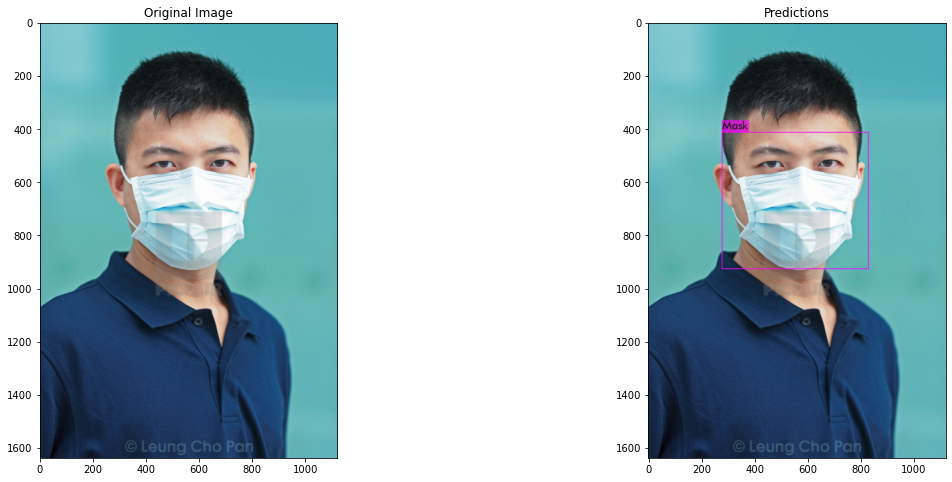

In [54]:
display_output(test_files[0])

#### <font color="blue">12.2 Scenario 2</font>

Testing with different angles of people wearing mask and other not wearing.

In [55]:
!darknet\darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector\test\test-image2.jpg -thresh .6 2 > NUL

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce GTX 1660 Ti 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                           ->  304 x 304 x 128 

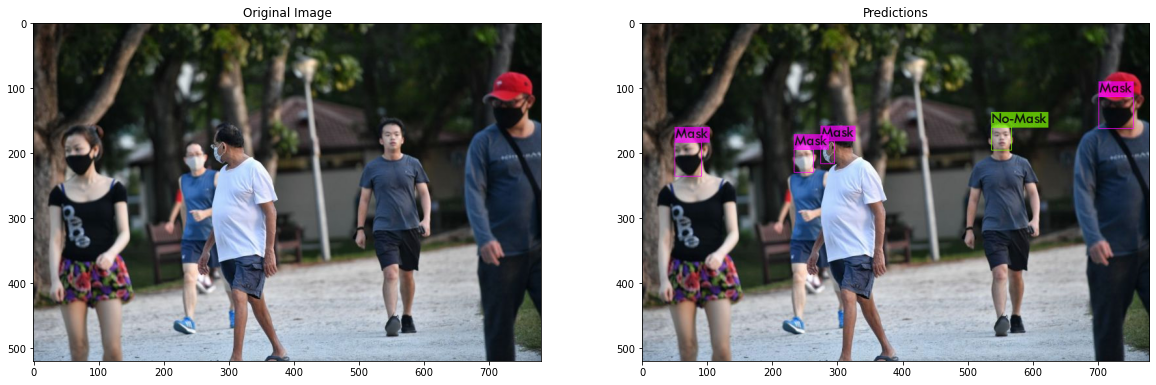

In [56]:
display_output(test_files[1])

#### <font color="blue">12.3 Scenario 3</font>

Testing with a crowd with and without facemask and different scales and variations

In [57]:
!darknet\darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector\test\test-image3.jpg -thresh .6 2 > NUL

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce GTX 1660 Ti 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                           ->  304 x 304 x 128 

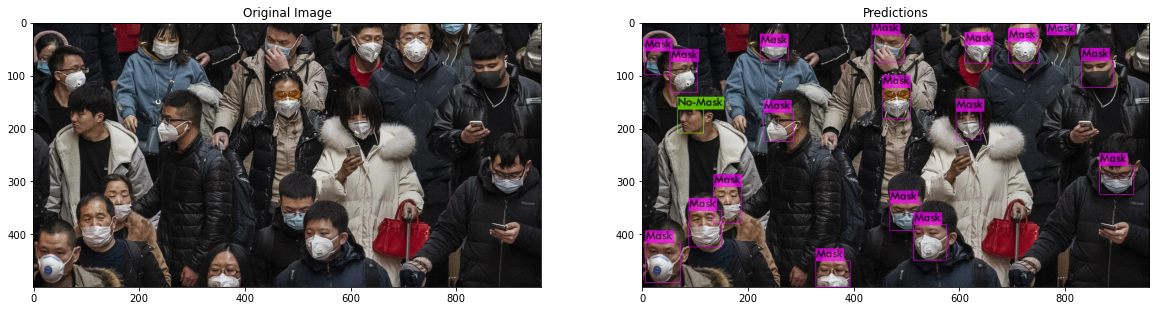

In [58]:
display_output(test_files[2])

#### <font color="blue">12.4 Scenario 4</font>

Testing with several people walking trough the plaza.

In [59]:
!darknet\darknet detector test $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector\test\test-image4.jpg -thresh .6 2 > NUL

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot 

 _DEBUG is used 
 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 110 K-images (1 Kilo-batches_64) 
video file: FacialMaskDetector\test\test-video2.mp4
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\videoio_registry.cpp (191) cv::`anonymous-namespace'::VideoBackendRegistry::VideoBackendRegistry VIDEOIO: Enabled backends(7, sorted by priority): FFMPEG(1000); GSTREAMER(990); INTEL_MFX(980); MSMF(970); DSHOW(960); CV_IMAGES(950); CV_MJPEG(940)
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\backend_plugin.cpp (370) cv::impl::getPluginCandidates Found 3 plugin(s) for FFMPEG
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\backend_plugin.cpp (175) cv::impl::DynamicLib::libraryLoad load C:\OpenCV\OpenCV-4.3.0\opencv\build\install\x64\vc16\bin

No-Mask: 88% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 87% 
No-Mask: 85% 
No-Mask: 83% 
No-Mask: 70% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 89% 
No-Mask: 87% 
No-Mask: 83% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 89% 
No-Mask: 85% 
No-Mask: 83% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 89% 
No-Mask: 79% 
No-Mask: 76% 
No-Mask: 75% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 95% 
No-Mask: 88% 
No-Mask: 81% 
No-Mask: 60% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 88% 
No-Mask: 87% 
No-Mask: 65% 
No-Mask: 63% 
No-Mask: 62% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 92% 
No-Mask: 88% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 87% 
No-Mask: 83% 
No-Mask: 80% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 87% 
No-Mask: 84% 
No-Mask: 80% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 96% 
No-Mask: 94% 
No-Mas

Mask: 86% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 100% 
Mask: 86% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 100% 
Mask: 80% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 76% 
Mask: 66% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 97% 
Mask: 62% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 86% 
Mask: 76% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 92% 
No-Mask: 63% 
Mask: 95% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 93% 
Mask: 95% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 85% 
No-Mask: 80% 
Mask: 87% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 96% 
No-Mask: 77% 
Mask: 89% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 66% 
Mask: 87% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 98% 
Mask: 62% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 99% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Obje


 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 91% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 79% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 78% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 76% 
No-Mask: 62% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 94% 
No-Mask: 85% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 73% 
No-Mask: 68% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 89% 
No-Mask: 76% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 89% 
No-Mask: 66% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 73% 
Mask: 97% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 70% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 78% 
Ma

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce GTX 1660 Ti 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                           ->  304 x 304 x 128 

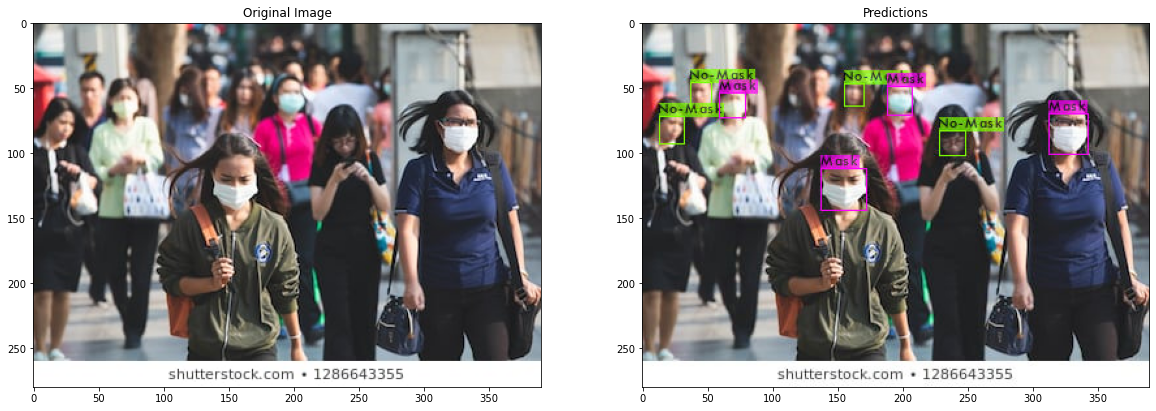

In [60]:
display_output(test_files[3])

#### <font color="blue">10.5 Scenario 5</font>

Testing over a video of people wearing or not wearing mask, good lighting conditions.  Probably will take between 1.5 to 3 min for generate the video.

In [61]:
!darknet\darknet detector demo $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector\test\test-video1.mp4 -thresh .6 2 -out_filename out-vid1.avi -dont_show
Audio(sound_file, autoplay=True)

 _DEBUG is used 
 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 110 K-images (1 Kilo-batches_64) 
video file: FacialMaskDetector\test\test-video1.mp4
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\videoio_registry.cpp (191) cv::`anonymous-namespace'::VideoBackendRegistry::VideoBackendRegistry VIDEOIO: Enabled backends(7, sorted by priority): FFMPEG(1000); GSTREAMER(990); INTEL_MFX(980); MSMF(970); DSHOW(960); CV_IMAGES(950); CV_MJPEG(940)
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\backend_plugin.cpp (370) cv::impl::getPluginCandidates Found 3 plugin(s) for FFMPEG
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\backend_plugin.cpp (175) cv::impl::DynamicLib::libraryLoad load C:\OpenCV\OpenCV-4.3.0\opencv\build\install\x64\vc16\bin

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce GTX 1660 Ti 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                           ->  304 x 304 x 128 



 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 99% 
No-Mask: 99% 
Mask: 99% 

FPS:5.2 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 99% 
No-Mask: 98% 
Mask: 99% 

FPS:5.3 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 99% 
No-Mask: 95% 
Mask: 99% 

FPS:5.3 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 99% 
No-Mask: 96% 
Mask: 99% 

FPS:5.3 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 98% 
No-Mask: 98% 
Mask: 88% 
Mask: 99% 

FPS:5.3 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 98% 
Mask: 93% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 98% 
Mask: 97% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 84% 
Mask: 98% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
Mask: 99% 
Mask: 99% 

FPS

#### <font color="blue">10.6 Scenario 6</font>

A video of the crowd.  Variable ligth conditions.  The video will be generated between 5 to 7 minutes.

In [62]:
!darknet\darknet detector demo $yolo_setup $yolo_test $yolo_best_weights FacialMaskDetector\test\test-video2.mp4 -thresh .6 2 -out_filename out-vid2.avi -dont_show
Audio(sound_file, autoplay=True)

Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.5 	 AVG_FPS:5.5

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100%

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 98% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask

 _DEBUG is used 
 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 110 K-images (1 Kilo-batches_64) 
video file: FacialMaskDetector\test\test-video2.mp4
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\videoio_registry.cpp (191) cv::`anonymous-namespace'::VideoBackendRegistry::VideoBackendRegistry VIDEOIO: Enabled backends(7, sorted by priority): FFMPEG(1000); GSTREAMER(990); INTEL_MFX(980); MSMF(970); DSHOW(960); CV_IMAGES(950); CV_MJPEG(940)
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\backend_plugin.cpp (370) cv::impl::getPluginCandidates Found 3 plugin(s) for FFMPEG
[ INFO:0] global C:\OpenCV\OpenCV-4.3.0\opencv\modules\videoio\src\backend_plugin.cpp (175) cv::impl::DynamicLib::libraryLoad load C:\OpenCV\OpenCV-4.3.0\opencv\build\install\x64\vc16\bin

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.3.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: GeForce GTX 1660 Ti 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   9 route  8 2 	                           ->  304 x 304 x 128 



No-Mask: 98% 
No-Mask: 66% 

FPS:5.1 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 92% 
No-Mask: 92% 

FPS:5.2 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 92% 

FPS:5.2 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 75% 

FPS:5.2 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 95% 

FPS:5.2 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 95% 

FPS:5.3 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 95% 

FPS:5.3 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 96% 
No-Mask: 90% 

FPS:5.3 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 94% 

FPS:5.3 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 92% 

FPS:5.3 	 AVG_FPS:5.1

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 94% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 94% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 93% 

FPS:5.3 	 AVG_FPS:5.3

 cvWriteFrame 
Objects

Finally, move the two videos to the result folder

In [63]:
!powershell -c "Move-Item out-vid1.avi FacialMaskDetector\\result\\yolov4\\"
!powershell -c "Move-Item out-vid2.avi FacialMaskDetector\\result\\yolov4\\"

Mask: 93% 
Mask: 96% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 98% 
No-Mask: 66% 
Mask: 78% 
Mask: 82% 
Mask: 97% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 98% 
No-Mask: 75% 
Mask: 93% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 98% 
No-Mask: 64% 
Mask: 98% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
Mask: 79% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
Mask: 92% 
Mask: 92% 
Mask: 96% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
Mask: 92% 
Mask: 93% 
Mask: 96% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
Mask: 90% 
Mask: 91% 
Mask: 97% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 66% 
Mask: 83% 
Mask: 88% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Mask: 89% 
Mask: 81% 
Mask: 61% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 6


 cvWriteFrame 
Objects:

No-Mask: 83% 
No-Mask: 82% 
No-Mask: 72% 
No-Mask: 64% 
No-Mask: 61% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 85% 
No-Mask: 81% 
No-Mask: 80% 
No-Mask: 72% 
No-Mask: 69% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 84% 
No-Mask: 80% 
No-Mask: 76% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 94% 
No-Mask: 88% 
No-Mask: 87% 
No-Mask: 75% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 95% 
No-Mask: 88% 
No-Mask: 87% 
No-Mask: 77% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 96% 
No-Mask: 88% 
No-Mask: 86% 
Mask: 60% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 89% 
No-Mask: 87% 
No-Mask: 87% 
No-Mask: 70% 
Mask: 97% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 86% 
No-Mask: 64% 
Mask: 98% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 85% 
No-Mask: 65% 
No-Mask: 62% 
Mask: 91% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:


Mask: 88% 
Mask: 89% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 64% 
Mask: 88% 
Mask: 90% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 66% 
Mask: 96% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 95% 
Mask: 87% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 80% 
Mask: 94% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 95% 
No-Mask: 74% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 62% 
Mask: 87% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 62% 
Mask: 88% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 82% 
No-Mask: 79% 
No-Mask: 63% 
Mask: 65% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 70% 
No-Mask: 61% 
Mask: 92% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 96% 
No-Mask: 72% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 75% 
Mask: 74% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 69% 



FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 94% 
No-Mask: 61% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 96% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 97% 
No-Mask: 80% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 96% 
No-Mask: 93% 
Mask: 98% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 97% 
No-Mask: 93% 
No-Mask: 65% 
Mask: 98% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 97% 
No-Mask: 91% 
Mask: 95% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
No-Mask: 96% 
Mask: 96% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 98% 
Mask: 76% 
Mask: 96% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 88% 
No-Mask: 88% 
Mask: 92% 
Mask: 1

No-Mask: 94% 
Mask: 61% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 96% 
No-Mask: 63% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 96% 
No-Mask: 63% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 95% 
No-Mask: 93% 
Mask: 71% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 94% 
No-Mask: 70% 
Mask: 66% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 81% 
No-Mask: 69% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 97% 
No-Mask: 92% 
No-Mask: 89% 
Mask: 63% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 98% 
No-Mask: 98% 
No-Mask: 94% 
No-Mask: 92% 
Mask: 69% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 97% 
No-Mask: 97% 
No-Mask: 94% 
No-Mask: 72% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 97% 
No-Mask: 96% 
No-Mask: 95% 
No-Mas


FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 74% 
Mask: 76% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 74% 
Mask: 77% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 70% 
No-Mask: 64% 
Mask: 73% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 97% 
No-Mask: 88% 
No-Mask: 61% 
Mask: 92% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 95% 
No-Mask: 77% 
No-Mask: 64% 
Mask: 80% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 96% 
No-Mask: 95% 
Mask: 95% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 98% 
No-Mask: 83% 
Mask: 69% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 97% 
No-Mask: 85% 
Mask: 68% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
Mask: 93% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

Objects:

No-Mask: 95% 
Mask: 77% 
Mask: 100% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 96% 
Mask: 78% 
Mask: 100% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 74% 
Mask: 100% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 83% 
Mask: 100% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 80% 
Mask: 100% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 85% 
Mask: 86% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 91% 
No-Mask: 73% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 87% 
No-Mask: 67% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 85% 
No-Mask: 74% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 90% 
No-Mask: 68% 
Mask: 100% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Objects:

No-Mask: 94% 
No-Mask: 93% 
Mask: 84% 
Mask: 99% 

FPS:5.4 	 AVG_FPS:5.4

 cvWriteFrame 
Obj

### <font color="blue">13. Conclusion</font>

This concludes the yolo v3 training and inference google colab notebook.

The disadvantage of GPU for large training datasets will leave you to wait the availability of free GPUs on the cloud (Colab/Kaggle).

There are other alternatives like Azure, Watson and Amazon Web Services, but those ones charge you by GPU usage over time.  

For this and other reasons people like to build their "low cost" deep learning rig to prepare their trainers. 

If you like to retrain, you could always start with the final weights and retrain over it, continuing with the last point of training will converge faster to your solution.

